In [9]:
%load_ext autoreload
%autoreload 2

import torch

import matplotlib.pyplot as plt
import seaborn as sns

from data_utils import *

from mixture_model.model import MixtureModel

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

mixture_model = MixtureModel.from_pretrained("./checkpoints/mixture_model_20240528_163332.pt").to(device)
mixture_model.eval()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


MixtureModel(
  (encoder): MixtureModelEncoder(
    (gnn_layers): ModuleList(
      (0): ECCConv(4, 16)
      (1): BatchNorm(16)
      (2): GELU(approximate='none')
      (3): ECCConv(16, 32)
      (4): BatchNorm(32)
      (5): GELU(approximate='none')
      (6): ECCConv(32, 64)
      (7): BatchNorm(64)
      (8): GELU(approximate='none')
      (9): ECCConv(64, 128)
      (10): BatchNorm(128)
      (11): GELU(approximate='none')
    )
    (z_head): ResidualBlock(
      (mlp): Sequential(
        (0): Linear(in_features=128, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): GELU(approximate='none')
        (3): Dropout(p=0, inplace=False)
        (4): Linear(in_features=128, out_features=8, bias=True)
      )
      (residual): Linear(in_features=128, out_features=8, bias=True)
      (activation): GELU(approximate='none')
    )
    (graph_pooling): GlobalGraphPooling(
      (fc_i): Linear(in_features=12

In [10]:
prop_norm_df = create_or_load_property_norm_df()
dataset = create_qm9_mixture_vae_dataset(
    device=device, 
    include_hydrogen=False,
    refresh_data_cache=False,
    properties=None,
    prop_norm_df=prop_norm_df
)
train_dataset, val_dataset, _ = create_qm9_data_split(dataset=dataset)

batch_size = 4096
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [11]:
val_batch = next(iter(val_loader))
z, eta = mixture_model.encode(val_batch)

In [16]:
num_generated_mols = 10000
num_atoms = torch.tensor([9] * num_generated_mols, dtype=torch.int64, device=device)
eta = mixture_model.decoder.sample_eta(num_atoms, device)
eta.shape

torch.Size([10000, 4])

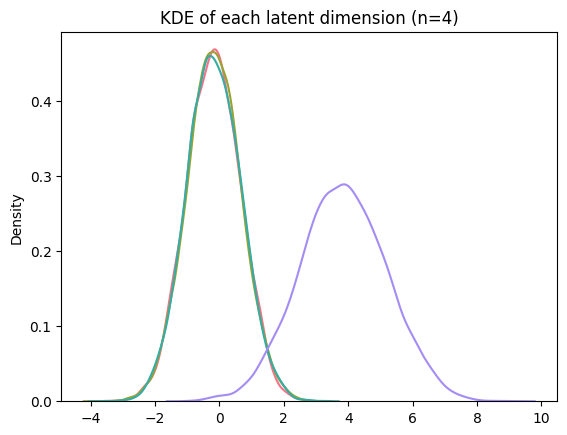

In [17]:
eta_cpu = eta.detach().cpu().numpy()
latent_dim = eta.shape[1]
for dim in range(eta.shape[1]):
    sns.kdeplot(eta_cpu[:, dim], legend=False, color=sns.color_palette("husl", latent_dim)[dim])

plt.title(f'KDE of each latent dimension (n={latent_dim})')
plt.show()

In [18]:
#num_atoms = torch.bincount(val_batch.batch)
pi = mixture_model.decoder.decode_eta(eta)
c = mixture_model.decoder.sample_c(pi=pi, num_atoms=num_atoms)

In [14]:
z = z.detach().cpu().numpy()

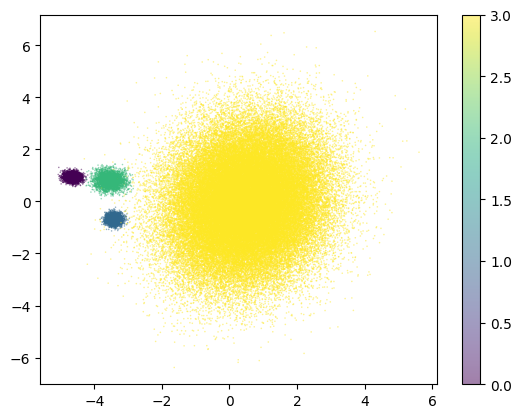

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# Assume mixture_model and other necessary variables are already defined

pi = mixture_model.decoder.decode_eta(eta)
c = mixture_model.decoder.sample_c(pi=pi, num_atoms=num_atoms)
z = mixture_model.decoder.sample_z(c=c).detach().cpu().numpy()
#z = z.detach().cpu().numpy()

# Get cluster labels from one-hot encoded vectors
cluster_labels = np.argmax(c.detach().cpu().numpy(), axis=1)

# Perform PCA and normalization
pca_fitted = PCA(n_components=2).fit(z)
Z_pca = pca_fitted.transform(z)
#Z_pca = MinMaxScaler().fit_transform(Z_pca)

df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']

# Create scatter plot with colors according to cluster labels
scatter = plt.scatter(x=df['x'], y=df['y'], c=cluster_labels, marker='.', s=5, alpha=0.5, edgecolors='none', cmap='viridis')
plt.colorbar(scatter)
plt.show()

In [103]:
means = mixture_model.decoder.cluster_means.detach().cpu()[0]

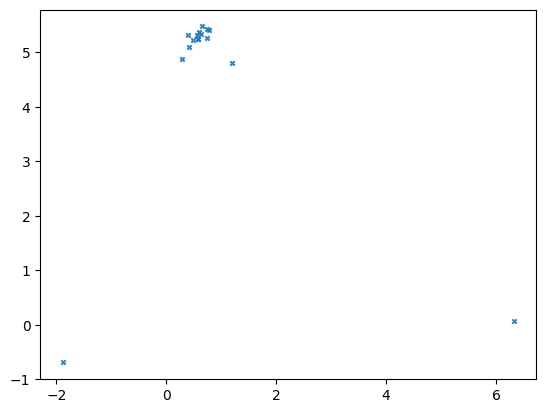

In [104]:
# do pca and normalize
Z_pca = pca_fitted.transform(means)
#Z_pca = MinMaxScaler().fit_transform(Z_pca)

df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']

scatter = plt.scatter(x=df['x'], y=df['y'], marker='x',
            s=10,alpha=0.9)
plt.show()